---
title: "EM Algorithm"
author: "Vivek Sivaramakrishnan"
format:
  html:
    theme: theme.scss
    toc: true
    html-math-method: katex
---

Colab: [Click here!](https://colab.research.google.com/drive/18AsBx3o0nJLi0aty50zReV6lTK33K3Dr?usp=sharing){target="_blank"}

# What is the EM Algorithm?

Nuanced situations end up providing complicated situations. One way of handling this is to view it as a mixture of simpler distributions - where the methodology of *mixing* is governed by the introduction of latent variables.

The problem can be then modelled into a Maximum Likelihood Estimation problem; but obtaining the parameters that best fit the data is not a straightforward task (no closed form solutions) (singularity problems)

A general technique for finding maximum likelihood estimators in latent variable models is the expectation-maximization (EM) algorithm:

- **E-step** (expectation): Use parameter estimates to update latent variable values.
- **M-step** (maximization): Obtain new parameter estimates by maximizing the log-likelihood function based on the latent variables obtained from **E-step**

We illustrate the workings of the *EM Algorithm* on the *Old-Faithful* dataset by posing it as a 2-component gaussian mixture model.

--2023-11-18 18:46:43--  https://raw.githubusercontent.com/data-8/materials-su19/master/materials/su19/hw/hw02/old_faithful.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2270 (2.2K) [text/plain]
Saving to: ‘old_faithful.csv.13’

old_faithful.csv.13 100%[===================>]   2.22K  --.-KB/s    in 0s      

2023-11-18 18:46:43 (23.1 MB/s) - ‘old_faithful.csv.13’ saved [2270/2270]



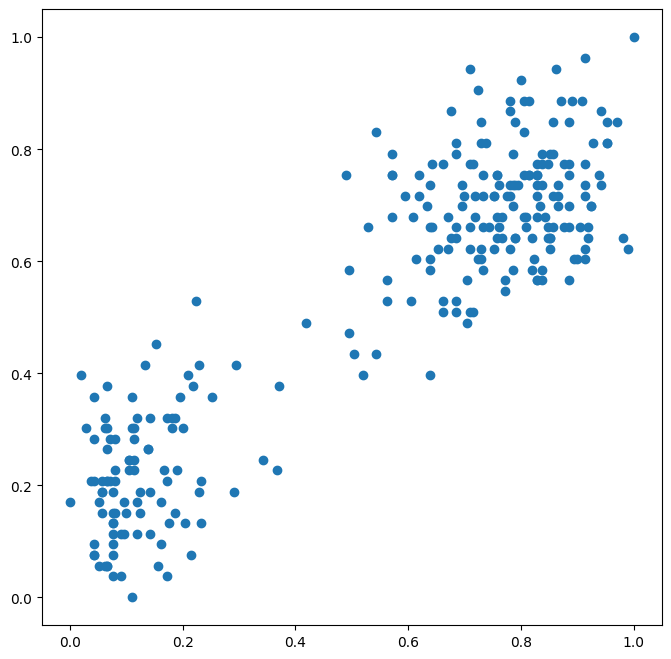

In [ ]:
!wget https://raw.githubusercontent.com/data-8/materials-su19/master/materials/su19/hw/hw02/old_faithful.csv

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
import pandas as pd
from matplotlib import mlab
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['figure.figsize'] = (8, 8)

X = pd.read_csv('old_faithful.csv')[['eruptions', 'waiting']].to_numpy()
X = MinMaxScaler().fit_transform(X)
plt.scatter(X[:, 0], X[:, 1])

# M, N = np.mgrid[min(X[:, 0]):max(X[:, 0]):0.01, min(X[:, 1]):max(X[:, 1]):0.01]
M, N = np.mgrid[0:1:0.01, 0:1:0.01]
grid = np.dstack((M, N))

Our problem is to estimate the parameters of the following K-component gaussian mixture pdf:

$$
p(\mathbf{x}) =  \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{Σ}_k)
$$

Where:

- $\pi_k =$ Probability that a random point belongs to the kth component (also called mixing coefficients) ($\sum{\pi_k} = 1$)
- $\mu_k, Σ_k$ and $\mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{Σ}_k)$ are the parameters and pdf of the kth components respectively.

## Introduction of Latent Variable

We introduce a K-dimensional latent variable $\mathbf{z}$; only one of the elements of $\mathbf{z}$ will be $1$ ($1$-of-$K$ encoding) (also a standard basis vector).

$$\mathbf{z} = \mathbf{e}_k$$

### Reformulating problem in terms of latent variable $\mathbf{z}$

We model the marginal distribuon over $\mathbf{z}$ using our mixing coefficients $\pi_k$:

$$p(\mathbf{z}=\mathbf{e}_k) = \pi_k$$

The conditional distribution of $\mathbf{x}$ over $\mathbf{z}$ can be similarly modelled:

$$p(\mathbf{x} | \mathbf{z}=\mathbf{e}_k) = \mathcal{N}(\mathbf{x}|\mu_k, Σ_k)$$

We then obtain $p(\mathbf{x})$ by summing the joint distribution over all possible $\mathbf{z}$ states:

$$p(x) = \sum_\mathbf{z}p(\mathbf{z})p(\mathbf{x}|\mathbf{z}) = \sum_{k=1}^K\pi_k\mathcal{N}(\mathbf{x}|\mu_k, Σ_k)$$

And done! We have formulated our goal using this latent variable $\mathbf{z}$. One more quantity of use is the conditional probablity of $\mathbf{z}=\mathbf{e}_k$ given $\mathbf{x}_i$ (which we will call $\lambda_ik$):

$$\lambda_{ik} \equiv p(\mathbf{z}=\mathbf{e}_k) = \frac{p(\mathbf{z}=\mathbf{e}_k)p(\mathbf{x}|\mathbf{z}_k=\mathbf{e}_k)}{\sum_{j=1}^K p(\mathbf{z}=\mathbf{e}_j)p(\mathbf{x}|\mathbf{z}_j=\mathbf{e}_j)} = \frac{\pi_k\mathcal{N}(\mathbf{x}|\mu_k, Σ_k)}{\sum_{j=1}^K \pi_j\mathcal{N}(\mathbf{x}|\mu_j, Σ_j)}$$

By the reformulation above, we have enabled the application of EM on our problem.

### Let's begin!

To get started, we perform the following initialization:
- Pick 2 points at random as cluster centres
- Hard-assign points based on proximity to centres

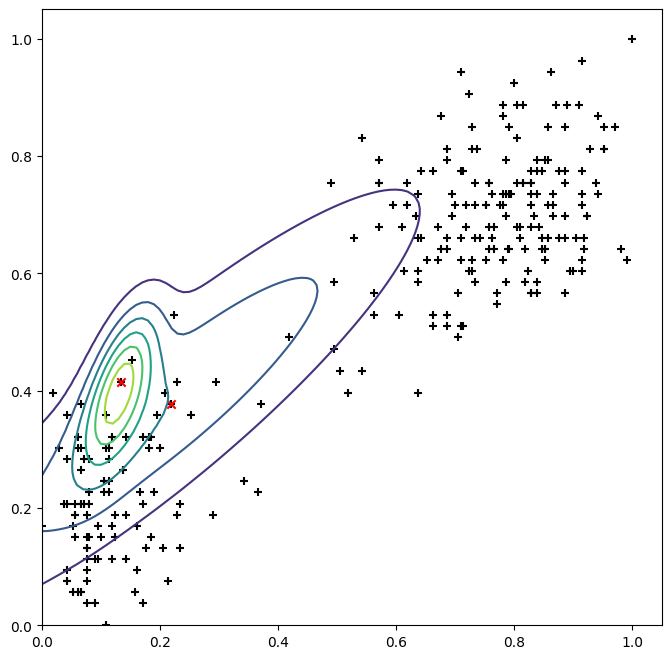

In [ ]:
K = 2

rng = np.random.default_rng(seed=12)
centres = X[rng.integers(low=0, high=len(X), size=K)]
l = np.array([(lambda i: [int(i==j) for j in range(K)])(np.argmin([np.linalg.norm(p-centre) for centre in centres])) for p in X])
pi = l.sum(axis=0)/l.sum()

cov = []
for i in range(K):
  cov.append(np.cov(X.T, ddof=0, aweights=l[:, i]))
cov = np.array(cov)

def plot():

  plt.scatter(X[:, 0], X[:, 1], color='black', marker='+')
  plt.scatter(centres[:, 0], centres[:, 1], color='red', marker='x')

  probability_grid = np.zeros(grid.shape[:2])
  for i in range(K):
    probability_grid += pi[i] * multivariate_normal(centres[i], cov[i]).pdf(grid)

  plt.contour(M, N, probability_grid)
  plt.show()

plot()

## Posing a Maximum Likelihood problem:

The log of the likelihood is the following:

$$\ln p(\mathbf{X}|\pi, \mu, Σ) = \sum_{n=1}^N\ln \left\{{\sum_{k=1}^K\pi_k\mathcal{N}(\mathbf{x}_n|\mu_k, \Sigma_k)}\right\}$$

### Maximization step

Taking derivate of above equation with $\mu_k$ and setting to zero yields the following:

$$
0 = -\sum_{n=1}^N \frac{\pi_k\mathcal{N}(\mathbf{x}_n|\mu_k, \Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal{N}(\mathbf{x}_n|\mu_j, \Sigma_j)} Σ_k(\mathbf{x}_n-\mu_k) ≡ -\sum_{n=1}^N \lambda_{nk}Σ_k(\mathbf{x}_n-\mu_k)
$$

Multiplying both sides by $Σ_k^{-1}$ (non-singular; invertible) and rearranging, we get:

$$\mathbf{\mu}_k = \frac{1}{N_k}\sum_{n=1}^{N}\lambda_{nk}\mathbf{x}_n$$

Where we define $N_k$ to be the *effective* number of points assigned to cluster *k*: $N_k = \sum_{n=1}^N \lambda_{nk}$

We follow a similar approach and derive the following ML estimates for $\Sigma_k$ and $\pi_k$:

$$Σ_k = \frac{1}{N_k}\sum_{n=1}^N\lambda_{nk}(\mathbf{x}_n-\mathbf{\mu}_k)(\mathbf{x}_n-\mathbf{\mu}_k)^T
\\\pi_k = \frac{N_k}{N}
$$

### Expectation step

Recompute $\lambda$ using the parameter values. Forumula mentioned again for completion sake:

$$\lambda_{ik} = \frac{\pi_k\mathcal{N}(\mathbf{x}|\mu_k, Σ_k)}{\sum_{j=1}^K \pi_j\mathcal{N}(\mathbf{x}|\mu_j, Σ_j)}$$

In [ ]:
# Expectation Step
def Max(l):
  pi = l.sum(axis=0)/l.sum()
  centres, cov = [], []
  for i in range(K):
    centres.append(np.dot(l[:, i], X)/l[:, i].sum())
    cov.append(np.cov(X.T, ddof=0, aweights=l[:, i]))

  return pi, np.array(centres), np.array(cov)

# Maximization step
def Exp(pi, centres, cov):
  l = []
  for i in X:
    p = np.array([pi[k] * multivariate_normal.pdf(i, mean=centres[k], cov=cov[k]) for k in range(K)])
    p = p/p.sum()
    l.append(p)

  return np.array(l)

# Convergence criterion
norm_theta = lambda pi, centres, cov: np.linalg.norm(np.r_[pi, centres.reshape(-1), cov.reshape(-1)])

In [ ]:
from IPython.display import HTML
from matplotlib import animation

prev_norm = norm_theta(pi, centres, cov)

fig, ax = plt.subplots()
artists = []

while True:
  frame = []
  frame.append(ax.scatter(X[:, 0], X[:, 1], color='black', marker='+'))
  frame.append(ax.scatter(centres[:, 0], centres[:, 1], color='red', marker='x'))

  probability_grid = np.zeros(grid.shape[:2])
  for i in range(K):
    probability_grid += pi[i] * multivariate_normal(centres[i], cov[i]).pdf(grid)

  frame += list(ax.contour(M, N, probability_grid).collections)
  artists.append(frame)

  l = Exp(pi, centres, cov)
  pi, centres, cov = Max(l)

  curr_norm = norm_theta(pi, centres, cov)

  if abs(curr_norm-prev_norm) < 0.00001:
    break
  else:
    prev_norm = curr_norm

plt.close()
anim = animation.ArtistAnimation(fig, artists, interval=200, repeat=False, blit=False);
HTML(anim.to_jshtml())

### Relation to $K$-Means?

There is a very close similarity. In fact $K$-Means is a restricted GMM clustering (initalize all $Σ_k$'s to $ϵ\mathbf{I}$, with $ϵ → 0$, and do not update in maximization step)

How does the above make it $K$-Means? We investigate $\lambda_{ik}$:

$$\lambda_{ik} = \frac{\pi_k\mathcal{N}(\mathbf{x}|\mu_k, Σ_k)}{\sum_{j=1}^K \pi_j\mathcal{N}(\mathbf{x}|\mu_j, Σ_j)} = \frac{\pi_k\exp \{-||\mathbf{x}_i-\mathbf{\mu}_k||^2/2ϵ\}}{\sum_{j=1}^K \pi_j\exp \{-||\mathbf{x}_i-\mathbf{\mu}_j||^2/2ϵ\}}$$

Let $\phi = \arg \min f(j) = ||\mathbf{x}_i-\mathbf{\mu}_j||^2$. Setting $ϵ → 0$, we see that in the denominator the $Φ$'th term goes to zero the slowest. Hence $\lambda_{n\phi} → 1$ while the others $→ 0$ (note that this results in a hard-clustering).

The above is equivalent to the K-means clustering paradigm; assign clusters based on proximity from cluster centers.

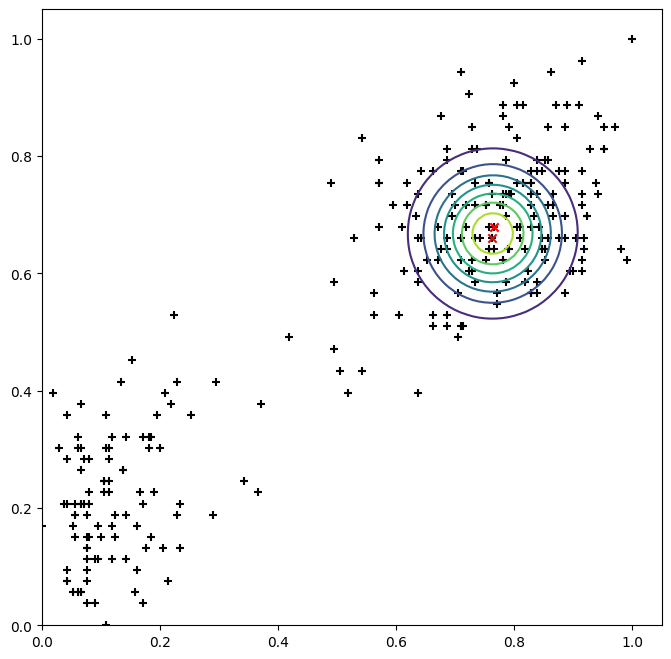

In [ ]:
# (Restricted) Maximization Step
def KM_Max(l):
  pi = l.sum(axis=0)/l.sum()
  centres, cov = [], []
  for i in range(K):
    centres.append(np.dot(l[:, i], X)/l[:, i].sum())
    cov.append(eps*np.eye(l.shape[1]))

  return pi, np.array(centres), np.array(cov)

K = 2
eps = 0.005

rng = np.random.default_rng(seed=72)
centres = X[rng.integers(low=0, high=len(X), size=K)]
l = np.array([(lambda i: [int(i==j) for j in range(K)])(np.argmin([np.linalg.norm(p-centre) for centre in centres])) for p in X])
pi = l.sum(axis=0)/l.sum()

cov = []
for i in range(K):
  cov.append(eps*np.eye(l.shape[1]))
cov = np.array(cov)

def plot():

  plt.scatter(X[:, 0], X[:, 1], color='black', marker='+')
  plt.scatter(centres[:, 0], centres[:, 1], color='red', marker='x')

  probability_grid = np.zeros(grid.shape[:2])
  for i in range(K):
    probability_grid += pi[i] * multivariate_normal(centres[i], cov[i]).pdf(grid)

  plt.contour(M, N, probability_grid)
  plt.show()

plot()

In [ ]:
a, b, c = KM_Max(l)
[[round(i, 5) for i in j] for j in Exp(a, b, c)[:5]]

[[0.99911, 0.00089], [0.0, 1.0], [0.00082, 0.99918], [0.0, 1.0], [1.0, 0.0]]

We see that the assignments are *close to* hard-clustering. Setting epsilon to a much smaller value will ensure this better.

For visual presentability, epsilon has been set as small as possible.

In [ ]:
from IPython.display import HTML
from matplotlib import animation

prev_norm = norm_theta(pi, centres, cov)

fig, ax = plt.subplots()
artists = []

while True:

  frame = []
  frame.append(ax.scatter(X[:, 0], X[:, 1], color='black', marker='+'))
  frame.append(ax.scatter(centres[:, 0], centres[:, 1], color='red', marker='x'))

  probability_grid = np.zeros(grid.shape[:2])
  for i in range(K):
    probability_grid += pi[i] * multivariate_normal(centres[i], cov[i]).pdf(grid)

  frame += list(ax.contour(M, N, probability_grid).collections)
  artists.append(frame)

  l = Exp(pi, centres, cov)
  pi, centres, cov = KM_Max(l)

  curr_norm = norm_theta(pi, centres, cov)

  if abs(curr_norm-prev_norm) < 0.0001:
    print(curr_norm-prev_norm)
    break
  else:
    prev_norm = curr_norm

plt.close()
anim = animation.ArtistAnimation(fig, artists, interval=1000, repeat=False, blit=False);
HTML(anim.to_jshtml())

-7.535850650119968e-05
